In [1]:
import datetime

from numba import jit, njit, prange
from numba import int32

import numpy as np
import xarray as xr

import sys, pdb, traceback

import matplotlib.pyplot as plt

import rotunno as rt

from scipy.special import exp1

In [141]:
# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport rotunno

In [86]:
print(exp1(40j))
print(calc_exp1(40j))
print(calc_exp1_alt(40j))

(-0.019020007896208772+0.016188792559887893j)
(1.5510397102357274-0.5205475841029514j)
(-0.01897175174356449+0.016212564016480434j)


In [257]:
def solve_qian(xiN=241,zetaN=200,tauN=32,sN=1999,alpha=3,U=0.625,L=0.1):

    print('Initialising')

    # Time interval
    delTau = 2*np.pi/tauN
    delS = 1/sN
    delZeta = 10/zetaN
    
    # Initialise solution arrays
    psi = np.zeros((xiN,zetaN,tauN), dtype=np.complex64)
    u = np.zeros((xiN,zetaN,tauN), dtype=np.complex64)
    w = np.zeros((xiN,zetaN,tauN), dtype=np.complex64)

    # Initialise domains
    xi = np.linspace(-6,6,xiN, dtype=np.float64)
    # Dont start at zero as exponential integral not defined there
    zeta = np.arange(delZeta,10+delZeta,delZeta, dtype=np.float64)
    tau = np.arange(0,2*np.pi,delTau, dtype=np.float64)
    s = np.arange(delS,1,delS, dtype=np.float64)  

    print('Integrating')
    psi, u, w = integrate_qian(xi,zeta,tau,s,alpha,U,L)

    ds = xr.Dataset({'psi':(('mode','tau','zeta','xi'),psi),
                     'u':(('mode','tau','zeta','xi'),u),
                     'w':(('mode','tau','zeta','xi'),w)},
                    {'mode': np.arange(1,4), 'tau': tau, 'zeta':zeta, 'xi':xi})

    print('Saving')
    now = str(datetime.datetime.now())[0:-7]
    now=now.replace('-', '').replace(':', '').replace(' ', '_')
    ds.attrs['U'] = U
    ds.attrs['L'] = L
    ds.to_netcdf('../datasets/qian_{}.nc'.format(now),
                 encoding={'psi':{'zlib':True, 'complevel':9},
                           'u':{'zlib':True, 'complevel':9},
                           'w':{'zlib':True, 'complevel':9}})
    
    for var in ['psi', 'u', 'w', 'xi', 'zeta', 'tau']:
        ds[var].attrs['units'] = '-'
    
    return ds

@jit(parallel=True)
def integrate_qian(xi,zeta,tau,s,alpha,U,L):
    
    psi = np.zeros((3, tau.size, zeta.size, xi.size), dtype=np.complex64) 
    u = np.zeros((3, tau.size, zeta.size, xi.size), dtype=np.complex64) 
    w = np.zeros((3, tau.size, zeta.size, xi.size), dtype=np.complex64)
    
    # Define alternative domains
    theta = calc_theta(s,alpha=3)
    
    k_3 = calc_k_3(theta,U)
    k0_3 = calc_k_3(0,U)
    
    k_2 = calc_k_2(theta,U)
    k0_2 = calc_k_2(0,U)
    
    # Don't need to worry about waves 2*pi/0.05 > 125 or < 0.005
    k_1 = np.linspace(0.2,1500,s.size)
    
    # Perform numerical integration
    for i in prange(xi.size):
        for j in range(zeta.size):
            for l in range(tau.size):
                                                
                # Calc psi1
                psi1_ig = calc_psi1(xi[i],zeta[j],tau[l],k_1,U,L)
                psi[0][l,j,i] = np.trapz(k_1,psi1_ig)
                
#                 pdb.set_trace()
                
                # Calc psi2
                psi2a_ig = calc_psi2a(xi[i],zeta[j],tau[l],s,alpha,U,L)
                psi2b_ig = calc_psi2b(xi[i],zeta[j],tau[l],s,alpha,U,L)
                
                psi2ab = np.trapz(s, psi2a_ig+psi2b_ig)
                
                psi2c = (-1/(2*U)*np.exp(1j*zeta[j]/U)
                         *calc_C2(xi[i],tau[l],k0_2,U,L)
                         *calc_ep0(-1j*zeta[j]/U))
                         
                psi[1][l,j,i] = psi2ab+psi2c
                
                # Calc psi3
                psi3a_ig = calc_psi3a(xi[i],zeta[j],tau[l],s,alpha,U,L)
                psi3b_ig = calc_psi3b(xi[i],zeta[j],tau[l],s,alpha,U,L)
                
                psi3ab = np.trapz(s, psi3a_ig+psi3b_ig)
                
                psi3c = (-U/2*calc_C3(xi[i],tau[l],k0_3,U,L)
                         *calc_ep0(1j*zeta[j]/U))
                
                psi[2][l,j,i] = psi3ab+psi3c
                
                
                # Calc u1
                u1_ig = calc_u1(xi[i],zeta[j],tau[l],k_1,U,L)
                u[0][l,j,i] = np.trapz(k_1,u1_ig)
                    
                # Calc u2
                u2a_ig = calc_u2a(xi[i],zeta[j],tau[l],s,alpha,U,L)
                u2b_ig = calc_u2b(xi[i],zeta[j],tau[l],s,alpha,U,L)
                
                u2ab = np.trapz(s,u2a_ig+u2b_ig)
                
                u2c = (-1j*np.exp(1j*zeta[j]/U)/(2*U**2)
                       *calc_C2(xi[i],tau[l],k0_2,U,L)
                       *(calc_ep0(-1j*zeta[j]/U)
                         -calc_exp1(1j*zeta[j]/U)))
                       
                u[1][l,j,i] = u2ab+u2c
                
                # Calc u3
                u3a_ig = calc_u3a(xi[i],zeta[j],tau[l],s,alpha,U,L)
                u3b_ig = calc_u3b(xi[i],zeta[j],tau[l],s,alpha,U,L)
                
                u3ab = np.trapz(s,u3a_ig+u3b_ig)

                u3c = (-1j/(2*np.pi)
                       *calc_C3(xi[i],tau[l],k0_3,U,L)
                       *calc_exp1(-1j*zeta[j]/U))              

                u[2][l,j,i] = u3ab+u3c
                                
                # Calc w1
                w1_ig = psi1_ig*1j*k_1
                w[0][l,j,i] = np.trapz(k_1,w1_ig)
                
                # Calc w2
                w2ab = np.trapz(s, 1j*(1-np.sin(theta))/U*(psi2a_ig+psi2b_ig))
                w2c = (-1j/(2*U**2)*np.exp(1j*zeta[j]/U)
                       *calc_C2(xi[i],tau[l],k0_2,U,L)
                       *(calc_ep0(-1j*zeta[j]/U)-calc_ep1(-1j*zeta[j]/U)))
                
                w[1][l,j,i] = w2ab+w2c
                
                # Calc w3
                w3ab = np.trapz(s, 1j*(1-np.sin(theta))/U*(psi3a_ig+psi3b_ig))
                w3c = (-1j/2*calc_C3(xi[i],tau[l],k0_3,U,L)
                       *(calc_ep0(1j*zeta[j]/U)-calc_ep1(1j*zeta[j]/U)))
                
                w[2][l,j,i] = w3ab+w3c

    psi = np.real(psi)
    u = np.real(u)
    w = -np.real(w)
    return psi, u, w

@jit(parallel=True)
def calc_exp1(z,n=100):
#     s = np.float64(0)
#     for i in np.arange(1,n):
#         i_f = np.float64(i)
#         s += (-z)**i_f/(i_f*np.math.factorial(i_f)) 
#     return -np.euler_gamma-np.log(z)-s
    return exp1(z)

# @jit(parallel=True)
# def calc_exp1_alt(z,n=100):
#     s = np.float64(0)
#     for i in np.arange(0,n):
#         i_f = np.float64(i)
#         s += np.exp(-z)/z*np.math.factorial(i_f)/(-z)**i_f
#     return s

@jit(parallel=True)
def calc_ep0(z):
    # Note this formula only applies if Re(z)>=0!
    return np.exp(z) + z*calc_exp1(-z)

@jit(parallel=True)
def calc_ep1(z):
    return (np.exp(z) + z*calc_ep0(z))/2
                           
@jit(parallel=True)
def calc_psi1(xi,zeta,tau,k,U,L):
    m=k/(1+k*U)
    psi1 = (-(1/2)*np.exp(-k*L)/(k**2+(1+k*U)**2)
            *(np.exp(1j*m*zeta)-np.exp(-zeta))
            *np.exp(1j*(k*xi+tau)))
    return psi1

@jit(parallel=True)
def calc_psi2a(xi,zeta,tau,s,alpha,U,L):
    theta = calc_theta(s,alpha)
    k = calc_k_2(theta,U)
    # Note only difference between u2a is sign
    psi2a = (1/(2*U)*calc_C2(xi,tau,k,U,L)*np.exp(-zeta)*np.cos(theta)
             *alpha*s**(alpha-1)*np.pi/2)
    return psi2a

@jit(parallel=True)
def calc_psi2b(xi,zeta,tau,s,alpha,U,L):
    theta = calc_theta(s, alpha=alpha)
    k = calc_k_2(theta,U)
    k0 = calc_k_2(0,U)
    psi2b = (-1/(2*U)*np.exp(1j*zeta/U)
             *(calc_C2(xi,tau,k,U,L)-calc_C2(xi,tau,k0,U,L))
             *np.exp(-1j*zeta/(U*np.sin(theta)))*np.cos(theta)
             *alpha*s**(alpha-1)*np.pi/2)
    return psi2b

@jit(parallel=True)
def calc_psi3a(xi,zeta,tau,s,alpha,U,L):
    theta = calc_theta(s, alpha)
    k = calc_k_3(theta,U)
    psi3a = (U/2*calc_C3(xi,tau,k,U,L)*np.exp(-zeta)*np.cos(theta)
             *alpha*s**(alpha-1)*np.pi/2)
    return psi3a

@jit(parallel=True)
def calc_psi3b(xi,zeta,tau,s,alpha,U,L):
    theta = calc_theta(s, alpha=alpha)
    k = calc_k_3(theta,U)
    k0 = calc_k_3(0,U)
    psi3b = (-U/2*(calc_C3(xi,tau,k,U,L)-calc_C3(xi,tau,k0,U,L))
             *np.exp(1j*zeta/(U*np.sin(theta)))*np.cos(theta)
             *alpha*s**(alpha-1)*np.pi/2)
    return psi3b
    
@jit(parallel=True)
def calc_u1(xi,zeta,tau,k,U,L):
    m=k/(1+k*U)
    u1 = (-(1/2)*np.exp(-k*L)/(k**2+(1+k*U)**2)
          *(1j*m*np.exp(1j*m*zeta)+np.exp(-zeta))
          *np.exp(1j*(k*xi+tau)))
    return u1
    
@jit(parallel=True)
def calc_u2a(xi,zeta,tau,s,alpha,U,L):
    theta = calc_theta(s,alpha=alpha)
    k = calc_k_2(theta,U)
    u2a = (-1/(2*U)*calc_C2(xi,tau,k,U,L)*np.exp(-zeta)*np.cos(theta)
           *alpha*s**(alpha-1)*np.pi/2)
    return u2a

@jit(parallel=True)
def calc_u2b(xi,zeta,tau,s,alpha,U,L):
    theta = calc_theta(s, alpha=alpha)
    k = calc_k_2(theta,U)
    k_0 = calc_k_2(0,U)
    u2b = (-1j/(2*U**2)*np.exp(1j*zeta/U)
           *(calc_C2(xi,tau,k,U,L)-calc_C2(xi,tau,k_0,U,L))
           *np.exp(-1j*zeta/(np.sin(theta)*U))*np.cos(theta)
           *alpha*s**(alpha-1)*np.pi/2
           +1j/(2*U**2)*np.exp(1j*zeta/U)
           *(calc_C2(xi,tau,k,U,L)-calc_C2(xi,tau,k_0,U,L))
           *np.exp(-1j*zeta/(np.sin(theta)*U))*np.cos(theta)/np.sin(theta)
           *alpha*s**(alpha-1)*np.pi/2)
    return u2b
    
@jit(parallel=True)
def calc_u3a(xi,zeta,tau,s,alpha,U,L):
    theta = calc_theta(s, alpha)
    k = calc_k_3(theta,U)
    u3a = (-U/(2*np.pi)*calc_C3(xi,tau,k,U,L)
           *np.exp(-zeta)*np.cos(theta)*alpha*s**(alpha-1)*np.pi/2)
    return u3a

@jit(parallel=True)
def calc_u3b(xi,zeta,tau,s,alpha,U,L):
    theta = calc_theta(s, alpha=alpha)
    k = calc_k_3(theta,U)
    k_0 = calc_k_3(0,U)
    u3b = (-1j/(2*np.pi)*(calc_C3(xi,tau,k,U,L)-calc_C3(xi,tau,k_0,U,L))
           *np.exp(1j*zeta/(U*np.sin(theta)))*(1/np.tan(theta))
           *alpha*s**(alpha-1)*np.pi/2)
    return u3b         
    
@jit(parallel=True)
def calc_C2(xi,tau,k,U,L):
    C2 = np.exp(-k*L)*np.exp(1j*(k*xi-tau))/(k**2+(U*k-1)**2)
    return C2

@jit(parallel=True)
def calc_C3(xi,tau,k,U,L):
    C3 = k**2*np.exp(-k*L)*np.exp(1j*(k*xi-tau))/(k**2+(U*k-1)**2)
    return C3

@jit(parallel=True)
def calc_theta(s,alpha=3):
    theta = (np.pi/2)*s**alpha
    return theta
    
@jit(parallel=True)
def calc_k_3(theta,U):
    k = 1/(U*(1-np.sin(theta)))
    return k

@jit(parallel=True)
def calc_k_2(theta,U):
    k = (1-np.sin(theta))/U
    return k

In [260]:
ds = solve_qian(xiN=41, zetaN=21, tauN=16, sN=2000, U=.625, L=0.1)

Initialising
Integrating
Saving


In [261]:
ds

<xarray.Dataset>
Dimensions:  (mode: 3, tau: 16, xi: 41, zeta: 21)
Coordinates:
  * mode     (mode) int64 1 2 3
  * tau      (tau) float64 0.0 0.3927 0.7854 1.178 ... 4.712 5.105 5.498 5.89
  * zeta     (zeta) float64 0.4762 0.9524 1.429 1.905 ... 8.571 9.048 9.524 10.0
  * xi       (xi) float64 -6.0 -5.7 -5.4 -5.1 -4.8 -4.5 ... 4.8 5.1 5.4 5.7 6.0
Data variables:
    psi      (mode, tau, zeta, xi) float32 0.04512498 0.04234324 ... 0.03080016
    u        (mode, tau, zeta, xi) float32 0.07095631 ... -0.010504975
    w        (mode, tau, zeta, xi) float32 0.010494804 ... 0.017598355
Attributes:
    U:        0.625
    L:        0.1

In [262]:
ds.sum(dim='mode').max()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    psi      float64 0.9158
    u        float64 1.418
    w        float64 0.5122

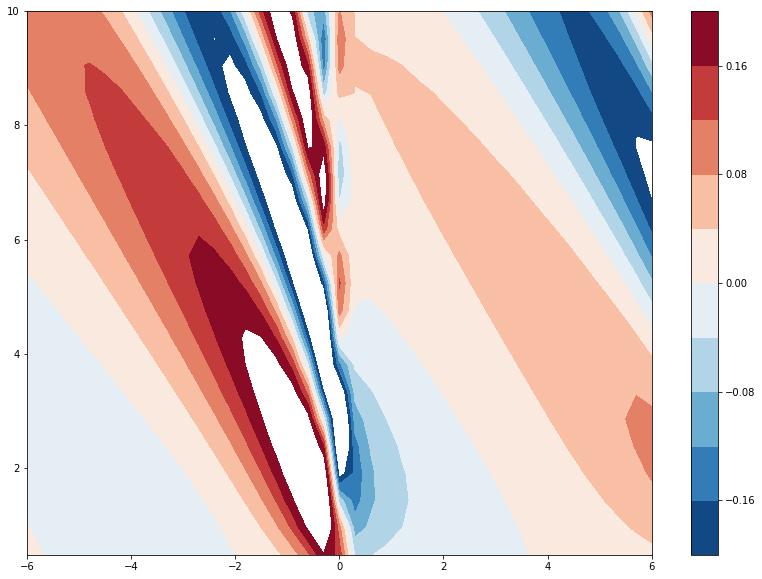

In [263]:
plt.figure(figsize=(14,10))
plt.contourf(ds.xi, ds.zeta, ds.w.sel(mode=1)[4], levels=np.arange(-.2,.2+0.02,0.04), cmap='RdBu_r')
# plt.clim([-1.5,1.5])
plt.colorbar()

In [142]:
ds = xr.open_dataset('../datasets/qian_20191117_200602.nc')

In [405]:
rt.animatePsi(ds.sum(dim='mode', keep_attrs=True).squeeze())

Animating stream function.
timestep 0
timestep 0
timestep 1
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
timestep 7
timestep 8
timestep 9
timestep 10
timestep 11
timestep 12
timestep 13
timestep 14
timestep 15


In [426]:
rt.animateVelocity(ds.sum(dim='mode', keep_attrs=True).squeeze())

Animating velocity field.
timestep 0
timestep 0
timestep 1
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
timestep 7
timestep 8
timestep 9
timestep 10
timestep 11
timestep 12
timestep 13
timestep 14
timestep 15
timestep 16
timestep 17
timestep 18
timestep 19
timestep 20
timestep 21
timestep 22
timestep 23
timestep 24
timestep 25
timestep 26
timestep 27
timestep 28
timestep 29
timestep 30
timestep 31


In [421]:
rt.animateVelocity(ds.sel(mode=2).squeeze())

Animating velocity field.
timestep 0
timestep 0
timestep 1
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
timestep 7
timestep 8
timestep 9
timestep 10
timestep 11
timestep 12
timestep 13
timestep 14
timestep 15
timestep 16
timestep 17
timestep 18
timestep 19
timestep 20
timestep 21
timestep 22
timestep 23
timestep 24
timestep 25
timestep 26
timestep 27
timestep 28
timestep 29
timestep 30
timestep 31


In [168]:
exp1(1j*0)

(inf+0j)